# Residential Rooftop PV Example

## Set up.

### Import packages.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("../../src"))

In [2]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import re                as re
import scipy.stats       as st
import seaborn           as sb
import tyche             as ty

from copy import deepcopy

## Scenario analyses.

### Load data.

#### The data are stored in a set of tab-separated value files in a folder.

In [3]:
designs = ty.Designs("data/pv_residential_validation")

#### Compile the production and metric functions for each technology in the dataset.

In [4]:
designs.compile()

### Examine the data.

#### The `functions` table specifies where the Python code for each technology resides.

In [5]:
designs.functions

,Style,Module,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
PV Generic,numpy,pv_residential_generic,capital_cost,fixed_cost,production,metrics,generic residential PV


Right now, only the style `numpy` is supported.

#### The `indices` table defines the subscripts for variables.

In [6]:
designs.indices.sort_values(["Technology", "Type", "Offset"])

Offset               Description Notes
Technology Type    Index                                              
PV Generic Capital Module            0             system module      
                   Inverter          1          system inverters      
                   BoS               2         balance of system      
           Fixed   System            0              whole system      
           Input   Strategic         0       strategic materials      
           Metric  Capital           0              capital cost      
                   LCOE              1  levelized cost of energy      
                   GHG               2      greenouse gas offset      
                   Strategic         3      strategic metal used      
                   Hazardous         4  hazardous waste produced      
                   Yield             5            specific yield      
                   Efficiency        6         module efficiency      
                   Lifetime          7           module lifetime      
           Output  Electricity       0     electricity generated      
                   Hazardous         1  hazardous waste produced      
                   GHG               2     greenhouse gas offset

#### The `designs` table contains the cost, input, efficiency, and price data for a scenario.

In [7]:
print(designs.designs)

                                                                                      Value  \
Technology Scenario     Variable          Index                                               
PV Generic CIGS 0       Input             Strategic     st.triang(0.5, loc=2520, scale=500)   
                        Input efficiency  Strategic    st.triang(0.5, loc=0.70, scale=0.05)   
                        Input price       Stategic                                        0   
                        Lifetime          BoS                                             1   
                                          Inverter                                        1   
...                                                                                     ...   
           Soft Costs 2 Output efficiency Hazardous                                       1   
                        Output price      Electricity                                     0   
                                          GHG     

In [8]:
designs.designs.xs("CIGS 0", level="Scenario", drop_level=False)

Value  \
Technology Scenario Variable          Index                                               
PV Generic CIGS 0   Input             Strategic     st.triang(0.5, loc=2520, scale=500)   
                    Input efficiency  Strategic    st.triang(0.5, loc=0.70, scale=0.05)   
                    Input price       Stategic                                        0   
                    Lifetime          BoS                                             1   
                                      Inverter                                        1   
                                      Module                                          1   
                    Output efficiency Electricity                                     1   
                                      GHG                                             1   
                                      Hazardous                                       1   
                    Output price      Electricity                                     0   
                                      GHG                                             0   
                                      Hazardous                                       0   
                    Scale             NaN                                             1   

                                                             Units  \
Technology Scenario Variable          Index                          
PV Generic CIGS 0   Input             Strategic           g/system   
                    Input efficiency  Strategic              %/100   
                    Input price       Stategic                 $/g   
                    Lifetime          BoS          system-lifetime   
                                      Inverter     system-lifetime   
                                      Module       system-lifetime   
                    Output efficiency Electricity            %/100   
                                      GHG                    %/100   
                                      Hazardous              %/100   
                    Output price      Electricity            $/kWh   
                                      GHG                  $/gCO2e   
                                      Hazardous                $/g   
                    Scale             NaN            system/system   

                                                                                             Notes  
Technology Scenario Variable          Index                                                         
PV Generic CIGS 0   Input             Strategic                                    zero by default  
                    Input efficiency  Strategic                                         no scaling  
                    Input price       Stategic                                     zero by default  
                    Lifetime          BoS                                per-lifetime computations  
                                      Inverter                           per-lifetime computations  
                                      Module                             per-lifetime computations  
                    Output efficiency Electricity  see parameter table for individual efficiencies  
                                      GHG          see parameter table for individual efficiencies  
                                      Hazardous    see parameter table for individual efficiencies  
                    Output price      Electricity                   not tracking electricity price  
                                      GHG                             not tracking hazardous waste  
                                      Hazardous                       not tracking hazardous waste  
                    Scale             NaN                                               no scaling

#### The `parameters` table contains additional techno-economic parameters for each technology.

In [9]:
designs.parameters.xs("CIGS 0", level="Scenario", drop_level=False).sort_values(["Technology", "Scenario", "Offset"])

Offset  \
Technology Scenario Parameter                             
PV Generic CIGS 0   Discount Rate                     0   
                    Insolation                        1   
                    System Size                       2   
                    Module Capital                    3   
                    Module Lifetime                   4   
                    Module Efficiency                 5   
                    Module Aperture                   6   
                    Module O&M Fixed                  7   
                    Module Degradation                8   
                    Location Capacity Factor          9   
                    Module Soiling Loss              10   
                    Inverter Capital                 11   
                    Inverter Lifetime                12   
                    Inverter Replacement             13   
                    Inverter Efficiency              14   
                    Hardware Capital                 15   
                    Direct Labor                     16   
                    Permitting                       17   
                    Customer Acquisition             18   
                    Installer Overhead & Profit      19   
                    Hazardous Waste Content          20   
                    Greenhouse Gas Offset            21   
                    Benchmark LCOC                   22   
                    Benchmark LCOE                   23   

                                                                                  Value  \
Technology Scenario Parameter                                                             
PV Generic CIGS 0   Discount Rate                                                  0.07   
                    Insolation                                                     1000   
                    System Size                                                      36   
                    Module Capital                    st.triang(0.5, loc=250, scale=75)   
                    Module Lifetime                st.triang(0.5, loc=25, scale=0.0025)   
                    Module Efficiency             st.triang(0.5, loc=0.210, scale=0.05)   
                    Module Aperture                 st.triang(0.5, loc=0.9, scale=9e-5)   
                    Module O&M Fixed                st.triang(0.5, loc=20, scale=0.002)   
                    Module Degradation           st.triang(0.5, loc=0.0075, scale=0.05)   
                    Location Capacity Factor        st.triang(0.5, loc=0.2, scale=2e-5)   
                    Module Soiling Loss            st.triang(0.5, loc=0.05, scale=5e-6)   
                    Inverter Capital                st.triang(0.5, loc=0.3, scale=3e-5)   
                    Inverter Lifetime              st.triang(0.5, loc=16, scale=0.0016)   
                    Inverter Replacement            st.triang(0.5, loc=0.5, scale=5e-5)   
                    Inverter Efficiency             st.triang(0.5, loc=0.9, scale=9e-5)   
                    Hardware Capital                st.triang(0.5, loc=80, scale=0.008)   
                    Direct Labor                    st.triang(0.5, loc=2000, scale=0.2)   
                    Permitting                      st.triang(0.5, loc=600, scale=0.06)   
                    Customer Acquisition            st.triang(0.5, loc=2000, scale=0.2)   
                    Installer Overhead & Profit  st.triang(0.5, loc=0.35, scale=3.5e-5)   
                    Hazardous Waste Content           st.triang(0.5, loc=305, scale=10)   
                    Greenhouse Gas Offset                                      4.49E-04   
                    Benchmark LCOC                                              2.51977   
                    Benchmark LCOE                                             0.086773   

                                                     Units Notes  
Technology Scenario Parameter                                     
PV Generic CI

#### The `results` table specifies the units of measure for results of computations.

In [10]:
designs.results

Units Notes
Technology Variable Index                            
PV Generic Cost     Cost               $/system      
           Metric   Capital             Œî$/Wdc      
                    Efficiency            %/100      
                    GHG          ŒîgCO2e/system      
                    Hazardous             g/kWh      
                    LCOE                Œî$/kWh      
                    Lifetime                 yr      
                    Strategic             g/kWh      
                    Yield                 hr/yr      
           Output   Electricity      kWh/system      
                    GHG          ŒîgCO2e/system      
                    Hazardous          g/system

### Evaluate the scenarios in the dataset.

In [11]:
scenario_results = designs.evaluate_scenarios(sample_count=500)

Evaluating PV Generic


/Users/tghosh/OneDrive - NREL/work_NREL/tyche/src/tyche/Designs.py:373: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  costs   = costs.append(  result.cost  )
/Users/tghosh/OneDrive - NREL/work_NREL/tyche/src/tyche/Designs.py:374: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputs = outputs.append(result.output)
/Users/tghosh/OneDrive - NREL/work_NREL/tyche/src/tyche/Designs.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(result.metric)
/Users/tghosh/OneDrive - NREL/work_NREL/tyche/src/tyche/Designs.py:388: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return organize("Cost", costs).append(
/Users/tghosh

In [12]:
scenario_results

Value  \
Technology Scenario     Sample Variable Index                        
PV Generic CIGS 0       1      Cost     Cost          28582.115018   
                               Metric   Capital          -0.785706   
                                        Efficiency        0.223109   
                                        GHG              -0.000449   
                                        Hazardous         0.066166   
...                                                            ...   
           Soft Costs 2 500    Metric   Strategic         0.000000   
                                        Yield          1278.385016   
                               Output   Electricity  266414.352317   
                                        GHG             119.620044   
                                        Hazardous     66016.352856   

                                                              Units  
Technology Scenario     Sample Variable Index                        
PV Generic CIGS 0       1      Cost     Cost               $/system  
                               Metric   Capital             Œî$/Wdc  
                                        Efficiency            %/100  
                                        GHG          ŒîgCO2e/system  
                                        Hazardous             g/kWh  
...                                                             ...  
           Soft Costs 2 500    Metric   Strategic             g/kWh  
                                        Yield                 hr/yr  
                               Output   Electricity      kWh/system  
                                        GHG          ŒîgCO2e/system  
                                        Hazardous          g/system  

[138000 rows x 2 columns]

#### Plot the results.

<AxesSubplot:ylabel='Frequency'>

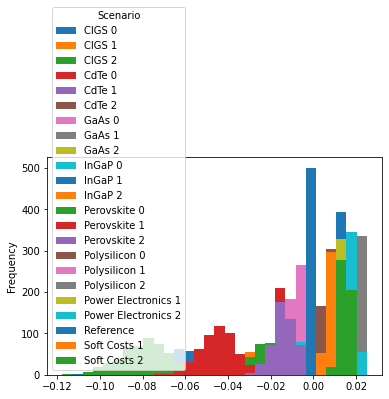

In [13]:
expert_results = scenario_results[["Value"]].xs(
    "LCOE", level="Index"
).rename(
    columns={"Value" : "LCOE [Δ$/kWh]"}
).unstack(
    ["Scenario"]
).xs("LCOE [Δ$/kWh]", axis=1, drop_level=True).reset_index(drop=True)
expert_results.plot.hist(bins=30)

### Make tornado plots for Expert A.

#### Remember base case LCOE.

In [14]:
base_lcoe = 0.10613269974604357

#### Define the factors.

In [15]:
tornado_factors = [
    "MCC", "MLT", "MEF", "MAP", "MOM",
    "MDR", "ICC", "ILT", "IRC", "IEF",
    "BCC", "BLR", "BPR", "BCA", "BOH",
]

#### Add the scenarios to the design.

In [16]:
designs.parameters

Offset  \
Technology Scenario     Parameter                      
PV Generic CIGS 0       Benchmark LCOC            22   
                        Benchmark LCOE            23   
                        Customer Acquisition      18   
                        Direct Labor              16   
                        Discount Rate              0   
...                                              ...   
           Soft Costs 2 Module Lifetime            4   
                        Module O&M Fixed           7   
                        Module Soiling Loss       10   
                        Permitting                17   
                        System Size                2   

                                                                             Value  \
Technology Scenario     Parameter                                                    
PV Generic CIGS 0       Benchmark LCOC                                     2.51977   
                        Benchmark LCOE                                    0.086773   
                        Customer Acquisition   st.triang(0.5, loc=2000, scale=0.2)   
                        Direct Labor           st.triang(0.5, loc=2000, scale=0.2)   
                        Discount Rate                                         0.07   
...                                                                            ...   
           Soft Costs 2 Module Lifetime       st.triang(0.5, loc=25, scale=0.0025)   
                        Module O&M Fixed       st.triang(0.5, loc=20, scale=0.002)   
                        Module Soiling Loss   st.triang(0.5, loc=0.05, scale=5e-6)   
                        Permitting              st.triang(0.5, loc=400, scale=100)   
                        System Size                                             36   

                                                 Units Notes  
Technology Scenario     Parameter                             
PV Generic CIGS 0       Benchmark LCOC           $/Wdc        
                        Benchmark LCOE           $/kWh        
                        Customer Acquisition  $/system   BCA  
                        Direct Labor          $/system   BLR  
                        Discount Rate           1/year    DR  
...                                                ...   ...  
           Soft Costs 2 Module Lifetime             yr   MLT  
                        Module O&M Fixed       $/kW/yr   MOM  
                        Module Soiling Loss      %/100   MSL  
                        Permitting            $/system   BPR  
                        System Size                m^2   SSZ  

[552 rows x 4 columns]

In [17]:
design_2015_actual    = designs.designs.xs   ("CIGS 0", level="Scenario")
parameter_2015_actual = designs.parameters.xs("CIGS 0", level="Scenario")
parameter_expert_a    = designs.parameters.xs("CIGS 1"   , level="Scenario")
for factor in tornado_factors:
    scenario_new = factor
    design_new = design_2015_actual.copy()
    design_new["Scenario"] = scenario_new
    designs.designs = designs.designs.append(design_new.reset_index().set_index(["Technology", "Scenario", "Variable", "Index"]))
    parameter_new = pd.concat([
        parameter_2015_actual[parameter_2015_actual["Notes"] != factor],
        parameter_expert_a   [parameter_expert_a   ["Notes"] == factor],
    ])
    parameter_new["Scenario"] = factor
    designs.parameters = designs.parameters.append(parameter_new.reset_index().set_index(["Technology", "Scenario", "Parameter"]))

/var/folders/sm/spdh5zkx26v6vh_fk8w7p8456l6sp0/T/ipykernel_31188/2266213522.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  designs.designs = designs.designs.append(design_new.reset_index().set_index(["Technology", "Scenario", "Variable", "Index"]))
/var/folders/sm/spdh5zkx26v6vh_fk8w7p8456l6sp0/T/ipykernel_31188/2266213522.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  designs.parameters = designs.parameters.append(parameter_new.reset_index().set_index(["Technology", "Scenario", "Parameter"]))
/var/folders/sm/spdh5zkx26v6vh_fk8w7p8456l6sp0/T/ipykernel_31188/2266213522.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  designs.designs = designs.designs.append(design_new.reset_index().set_index(["Technology", "Sce

#### Recompile the design.

In [18]:
designs.compile()

#### Compute the results.

In [19]:
scenario_results = designs.evaluate_scenarios(sample_count=500)
scenario_results.shape

Evaluating PV Generic


/Users/tghosh/OneDrive - NREL/work_NREL/tyche/src/tyche/Designs.py:373: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  costs   = costs.append(  result.cost  )
/Users/tghosh/OneDrive - NREL/work_NREL/tyche/src/tyche/Designs.py:374: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputs = outputs.append(result.output)
/Users/tghosh/OneDrive - NREL/work_NREL/tyche/src/tyche/Designs.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(result.metric)
/Users/tghosh/OneDrive - NREL/work_NREL/tyche/src/tyche/Designs.py:388: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return organize("Cost", costs).append(
/Users/tghosh

(228000, 2)

#### Make the tornado plot.

In [20]:
tornado_results =scenario_results[[
    "Value"
]].xs(
    "LCOE", level="Index"
).rename(
    columns={"Value" : "LCOE [$/kWh]"}
).reset_index(
    ["Technology", "Sample", "Variable"], drop=True
).drop(
    ["CIGS 0", "CIGS 1", "CIGS 2"]
).reset_index(
).sort_values(
    "LCOE [$/kWh]", ascending = False
)
tornado_results["LCOE Reduction [%]"] = 100 * tornado_results["LCOE [$/kWh]"] / 0.106125

In [21]:
pl.figure(figsize=(8, 6), dpi = 300)

<Figure size 2400x1800 with 0 Axes>

<Figure size 2400x1800 with 0 Axes>

In [22]:
sb.set(font_scale = 1)

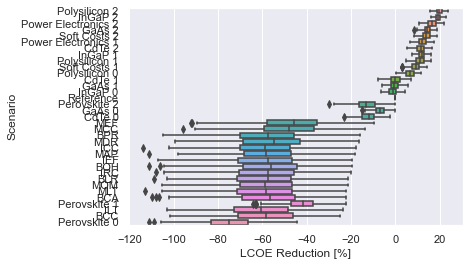

In [23]:
ax = sb.boxplot(
    data = tornado_results,
    y = "Scenario",
    x = "LCOE Reduction [%]"
)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

In [24]:
z = list(ax.get_children())

In [25]:
sb.barplot(
    data = tornado_results.groupby("Scenario").agg(np.mean).reset_index().sort_values(
    "LCOE [$/kWh]", ascending = False,
),
    y = "Scenario",
    x = "LCOE Reduction [%]",
    color = "lightblue",
    ax = ax,
)

<AxesSubplot:xlabel='LCOE Reduction [%]', ylabel='Scenario'>

In [26]:
for zi in z:
    zi.set_zorder(1000)

In [27]:
ax.set_xlabel("LCOE Reduction [%]",fontsize=15)
ax.set_ylabel("Scenario",fontsize=15)
ax.tick_params(labelsize=15)

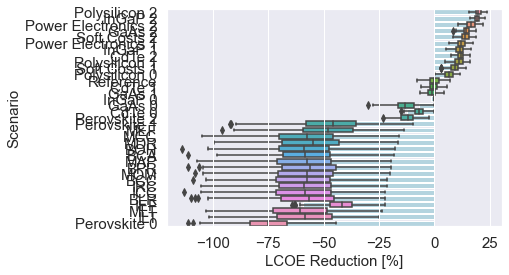

In [28]:
ax.figure

In [29]:
ax.figure.savefig("pv_residential_validation.png", dpi = 300, bbox_inches = "tight")